### Weather Prediction System using RNN

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import model_from_json
import warnings

warnings.filterwarnings('ignore')

2021-12-18 08:11:55.663813: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-12-18 08:11:55.663845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Stores paths of all csv files

path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "./data/*.csv"))

In [3]:
# Reading stored csv files and appending them to a single dataframe, while at the same time dropping
# unnecessary columns

df = pd.DataFrame()
for f in csv_files:
    
    temp = pd.read_csv(f)
    if 'Dcode' in temp.columns: temp.drop('Dcode', inplace = True, axis = 1)
        
    if len(temp.columns) > 10:
        temp.drop(temp.columns[[0, 2, 4, 5, 7, 9]], inplace = True, axis = 1)
    else:
        temp.drop(temp.columns[[1, 3, 4, 6, 8]], inplace = True, axis = 1)
    
    mapping = {
        temp.columns[0]: 'District',
        temp.columns[1]: 'Date',
        temp.columns[2]: 'temp',
        temp.columns[3]: 'humid',
        temp.columns[4]: 'wind'
    }
    temp.rename(columns = mapping, inplace = True)
    
    df = pd.concat([df, temp])

In [4]:
df

,District,Date,temp,humid,wind
0,Adilabad,2020-04-01,37.4,85.4,NaN
1,Adilabad,2020-04-02,38.6,84.6,NaN
2,Adilabad,2020-04-03,38.6,72.4,NaN
3,Adilabad,2020-04-04,38.2,91.9,NaN
4,Adilabad,2020-04-05,38.8,80.3,NaN
...,...,...,...,...,...
53005,Narayanpet,2021-03-27,38.4,51.6,NaN
53006,Narayanpet,2021-03-28,38.7,73.5,NaN
53007,Narayanpet,2021-03-29,38.6,70.1,NaN
53008,Narayanpet,2021-03-30,40.0,62.2,NaN


In [5]:
# Changing the dtype of Date column to datetime

df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Grouping dataframe by district and date, this method calculates average values of similar occurrences

df = df.groupby(['District', 'Date']).mean().reset_index()

In [7]:
# Checking for null values

df.isnull().sum()

District       0
Date           0
temp           0
humid          0
wind        4803
dtype: int64

In [8]:
# Replacing null values with mean of the column

df['wind'].fillna(value = df['wind'].mean(), inplace = True)

In [9]:
df.isnull().sum()

District    0
Date        0
temp        0
humid       0
wind        0
dtype: int64

In [10]:
# District names according to latest data

districts = ['Adilabad', 'Bhadradri Kothagudem', 'Hyderabad', 'Jagtial', 'Jangaon',
             'Jayashankar', 'Jogulamba Gadwal', 'Kamareddy', 'Karimnagar', 'Khammam',
             'Kumuram Bheem', 'Mahabubabad', 'Mahabubnagar', 'Mancherial', 'Medak',
             'Medchal-Malkajgiri', 'Mulugu', 'Nagarkurnool', 'Nalgonda', 'Narayanpet',
             'Nirmal', 'Nizamabad', 'Peddapalli', 'Rajanna Sircilla', 'Rangareddy',
             'Sangareddy', 'Siddipet', 'Suryapet', 'Vikarabad', 'Wanaparthy',
             'Warangal Rural', 'Warangal Urban', 'Yadadri Bhuvanagiri']

# Features on which prediction would be done

features = ['temp', 'humid', 'wind']

In [11]:
# Removing districts which are not present in latest data

for i in df.index:
    if df['District'][i] not in districts:
        df.drop(i, inplace = True)

In [12]:
df

,District,Date,temp,humid,wind
0,Adilabad,2019-01-01,27.443478,75.134783,6.359091
1,Adilabad,2019-01-02,29.543478,77.769565,6.290909
2,Adilabad,2019-01-03,31.908696,78.378261,5.200000
3,Adilabad,2019-01-04,31.508696,84.613043,5.659091
4,Adilabad,2019-01-05,31.373913,82.913043,4.904545
...,...,...,...,...,...
34075,Yadadri Bhuvanagiri,2021-11-26,32.817647,97.782353,0.000000
34076,Yadadri Bhuvanagiri,2021-11-27,32.470588,95.247059,0.000000
34077,Yadadri Bhuvanagiri,2021-11-28,30.658824,90.652941,0.000000
34078,Yadadri Bhuvanagiri,2021-11-29,30.247059,95.729412,0.000000


In [13]:
# Fucntion which splits data into train and test by district

def data_splitting(df = df, district = 'Adilabad'):
    
    df_sample = df[df['District'] == district]
    # Converts date to numerical value which can used as an independent variable in regression
    # For e.g., the first date recorded becomes the 0th day while the last date becomes the (n - 1)th day
    df_sample['Date'] = (df_sample['Date'] - df_sample['Date'].min()) / np.timedelta64(1, 'D')
    
    print(df_sample)
    
    # Splits data into 80:20 ratio
    train_size = int(len(df_sample) * 0.8)
    train_dataset, test_dataset = df_sample.iloc[:train_size], df_sample.iloc[train_size:]
    
    # Plots various feature variables w.r.t. to date column
    fig, axs = plt.subplots(3, figsize = (10, 10), sharex = True)

    axs[0].plot(train_dataset.temp)
    axs[0].plot(test_dataset.temp)
    plt.setp(axs[0], ylabel = 'Temperature (°C)')

    axs[1].plot(train_dataset.humid)
    axs[1].plot(test_dataset.humid)
    plt.setp(axs[1], ylabel = 'Humidity (%)')

    axs[2].plot(train_dataset.wind)
    axs[2].plot(test_dataset.wind)
    plt.setp(axs[2], ylabel = 'Wind Speed (Kmph)', xlabel = 'Day')

    fig.legend(['Train set', 'Test set'], loc = 'upper right')
    
    return train_dataset, test_dataset, district

In [14]:
# Function for model training

def RNN(X_train, y_train, district, feature):
    
    # LSTM is a type of RNN which handles sequential data very well
    # Dropout prevents model from overfitting
    model = Sequential()
    model.add(LSTM (units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM (units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam')
    
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, batch_size = 32, verbose = 0)
    
    # Saves the model in json format and weights in h5 format district wise
    folder_path = './{folder}/' .format(folder = district)
    if os.path.isdir(folder_path): os.chdir(folder_path)
    else:
        os.makedirs(folder_path)
        os.chdir(folder_path)
        
    file_path = '{feature}.json' .format(feature = feature)
    if os.path.isfile(file_path): os.remove(file_path)
    with open(file_path, 'w') as json_file:
        json_file.write(model.to_json())
    
    file_path = '{feature}.h5' .format(feature = feature)
    if os.path.isfile(file_path): os.remove(file_path)
    model.save_weights('{feature}.h5' .format(feature = feature))
    
    print('{district} {feature} model saved to disk' .format(district = district, feature = feature))
    
    os.chdir('../')
    
    return history, model

In [15]:
# Function for transforming the data to fit the data

def modelling_training(train_dataset, test_dataset, district, feature = 'temp'):

    # Normalizes the dependent and independent variables
    scaler_x = MinMaxScaler(feature_range = (0,1))
    scaler_y = MinMaxScaler(feature_range = (0,1))
    
    y_train = train_dataset[feature]
    X_train = train_dataset.drop(['District', feature], axis = 1)

    y_test = test_dataset[feature]
    X_test = test_dataset.drop(['District', feature], axis = 1)

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    input_scaler = scaler_x.fit(X_train)
    output_scaler = scaler_y.fit(y_train)

    train_y_norm = output_scaler.transform(y_train)
    train_x_norm = input_scaler.transform(X_train)

    test_y_norm = output_scaler.transform(y_test)
    test_x_norm = input_scaler.transform(X_test)

    # Implements window sliding technique which uses prior time steps to predict the next step
    # and also converts the data to a 3D format.
    def create_dim(X, y, time_steps = 1):

        Xs, Ys = [], []
        for i in range(len(X) - time_steps):
            v = X[i:i + time_steps, :]
            Xs.append(v)
            Ys.append(y[i + time_steps])

        return np.array(Xs), np.array(Ys)

    X_train, y_train = create_dim(train_x_norm, train_y_norm, 10)
    X_test, y_test = create_dim(test_x_norm, test_y_norm, 10)
    
    print(feature)
    print('X_train', X_train.shape)
    print('y_train', y_train.shape)
    print('X_test', X_test.shape)
    print('y_test', y_test.shape)
    
    history, model = RNN(X_train, y_train, district, feature)
    
    # Plot between loss and validation loss during training
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc = 'upper right')
    plt.title('{feature}' .format(feature = feature))
    plt.show()
    
    # De-normalizing the variables
    y_test = scaler_y.inverse_transform(y_test)
    y_train = scaler_y.inverse_transform(y_train)
    
    # Model predicting the testing suite
    y_pred = scaler_y.inverse_transform(model.predict(X_test))
    
    # Plot visualizing the actual and predicted values
    plt.figure(figsize = (10, 6))
    range_future = len(y_pred)
    plt.plot(np.arange(range_future), np.array(y_test), label = 'True Future')
    plt.plot(np.arange(range_future),np.array(y_pred), label = 'Prediction')
    plt.legend(loc = 'upper right')
    plt.title('{feature}' .format(feature = feature))
    plt.show()

      District    Date       temp      humid      wind
0     Adilabad     0.0  27.443478  75.134783  6.359091
1     Adilabad     1.0  29.543478  77.769565  6.290909
2     Adilabad     2.0  31.908696  78.378261  5.200000
3     Adilabad     3.0  31.508696  84.613043  5.659091
4     Adilabad     4.0  31.373913  82.913043  4.904545
...        ...     ...        ...        ...       ...
1059  Adilabad  1060.0  31.600000  94.672222  0.000000
1060  Adilabad  1061.0  30.911111  93.588889  0.000000
1061  Adilabad  1062.0  29.805556  88.844444  0.000000
1062  Adilabad  1063.0  28.972222  83.577778  0.000000
1063  Adilabad  1064.0  27.461111  86.588889  0.000000

[1064 rows x 5 columns]
temp
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)


2021-12-18 08:12:06.543480: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-18 08:12:06.543505: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-18 08:12:06.543523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Venom): /proc/driver/nvidia/version does not exist
2021-12-18 08:12:06.543682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 08:12:06.568838: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
20

Adilabad temp model saved to disk


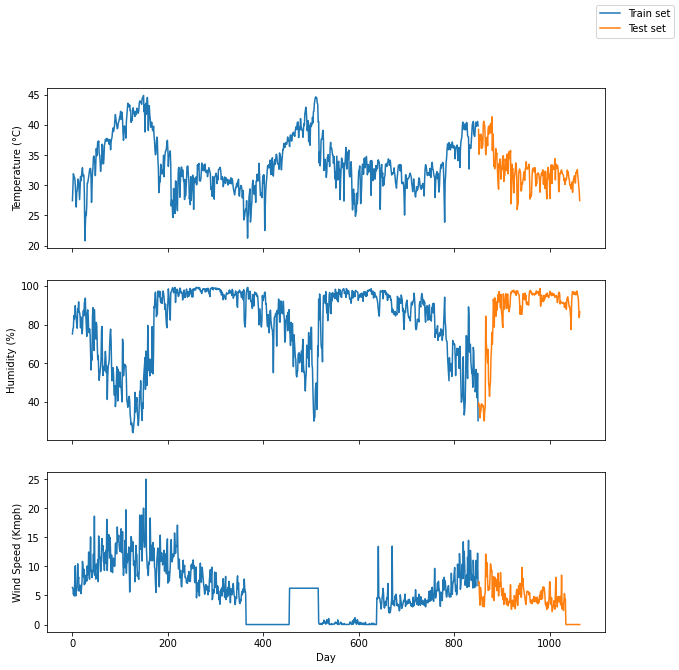

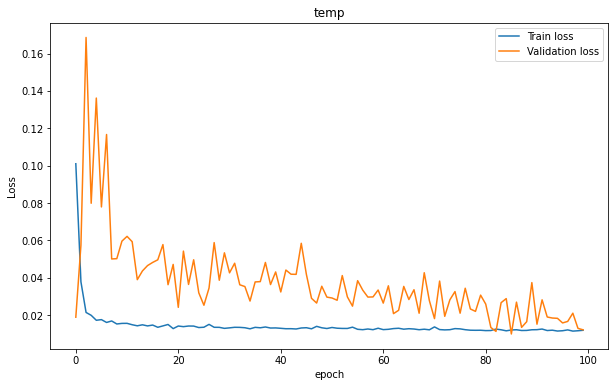

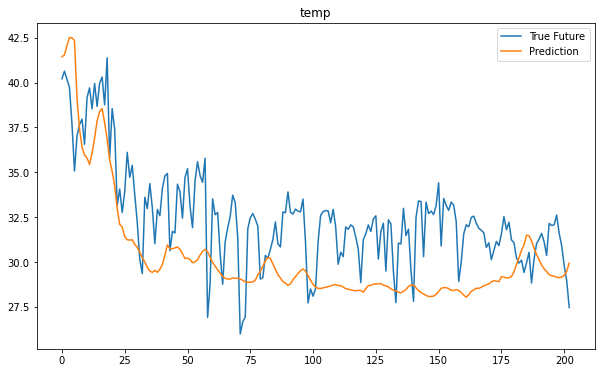

humid
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Adilabad humid model saved to disk


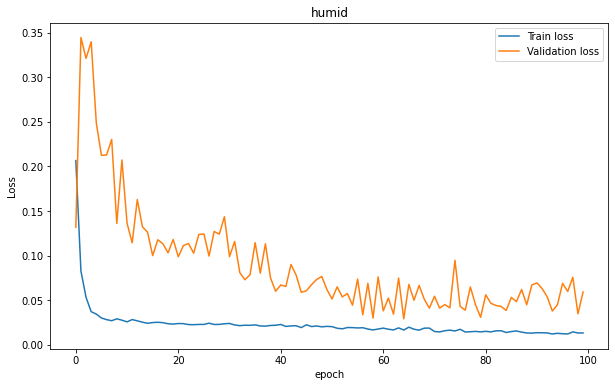

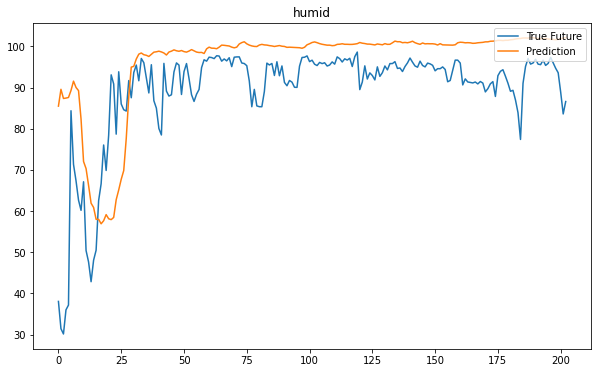

wind
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Adilabad wind model saved to disk


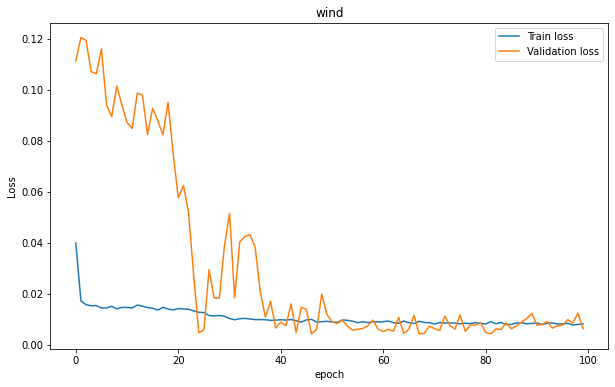

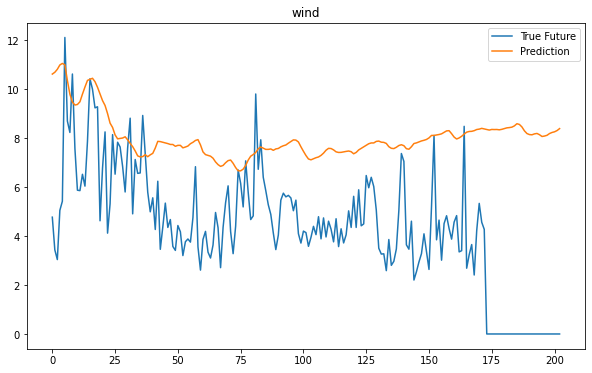

                  District   Date       temp      humid      wind
1064  Bhadradri Kothagudem    0.0  31.278261  97.156522  6.245036
1065  Bhadradri Kothagudem    1.0  30.591304  98.113043  6.245036
1066  Bhadradri Kothagudem    2.0  31.365217  97.617391  6.245036
1067  Bhadradri Kothagudem    3.0  31.447826  97.826087  6.245036
1068  Bhadradri Kothagudem    4.0  31.600000  97.226087  6.245036
...                    ...    ...        ...        ...       ...
1393  Bhadradri Kothagudem  329.0  33.130435  97.234783  0.000000
1394  Bhadradri Kothagudem  330.0  32.521739  97.600000  0.000000
1395  Bhadradri Kothagudem  331.0  31.447826  96.008696  0.000000
1396  Bhadradri Kothagudem  332.0  28.895652  96.852174  0.000000
1397  Bhadradri Kothagudem  333.0  29.217391  97.082609  0.000000

[334 rows x 5 columns]
temp
X_train (257, 10, 3)
y_train (257, 1)
X_test (57, 10, 3)
y_test (57, 1)
Bhadradri Kothagudem temp model saved to disk


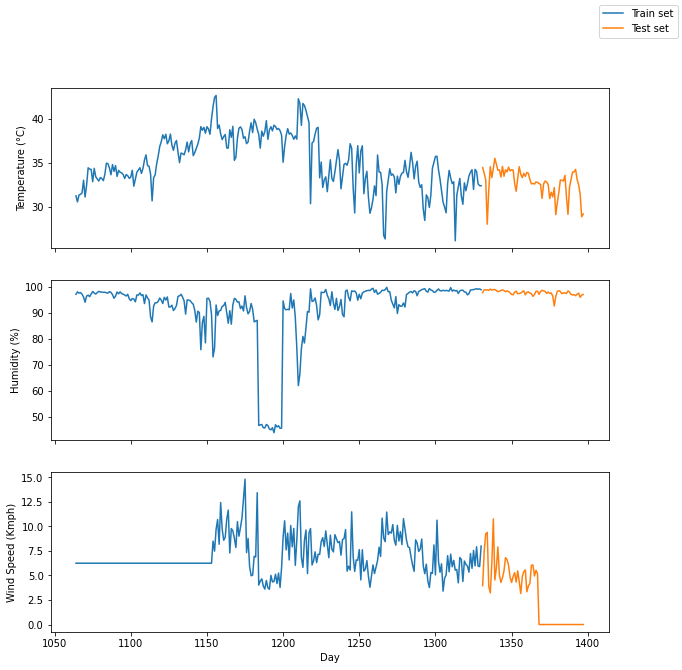

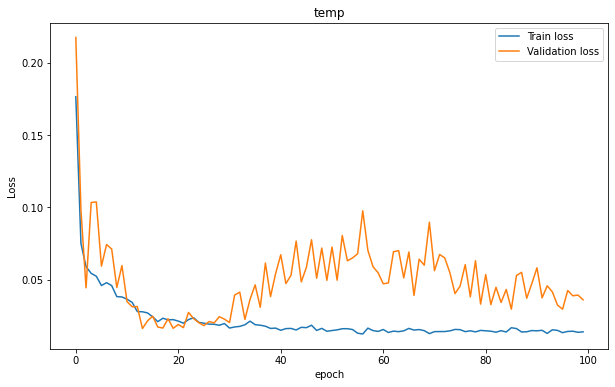

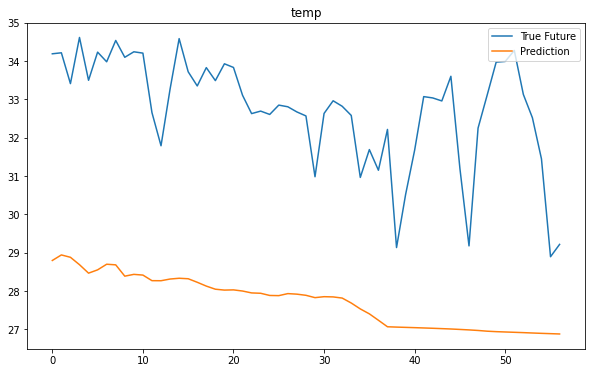

humid
X_train (257, 10, 3)
y_train (257, 1)
X_test (57, 10, 3)
y_test (57, 1)
Bhadradri Kothagudem humid model saved to disk


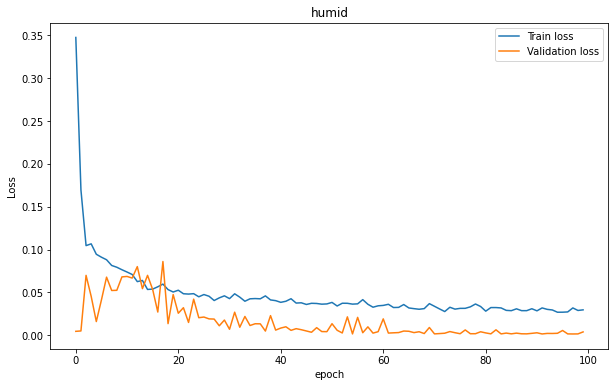

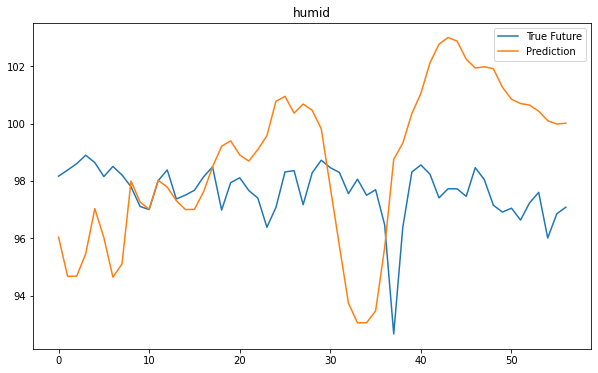

wind
X_train (257, 10, 3)
y_train (257, 1)
X_test (57, 10, 3)
y_test (57, 1)
Bhadradri Kothagudem wind model saved to disk


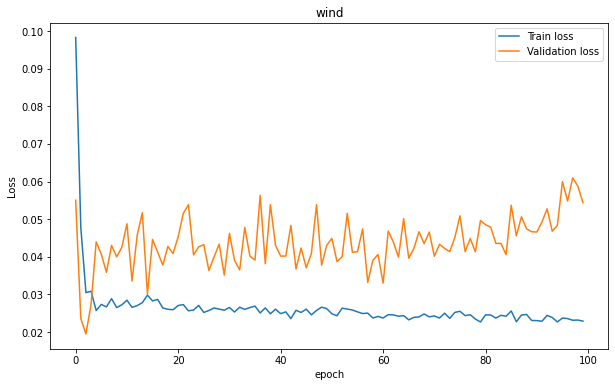

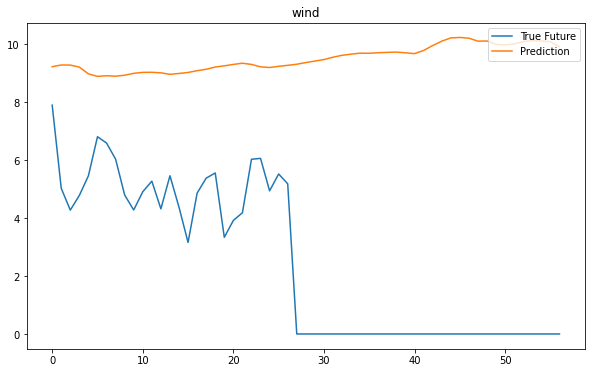

       District    Date       temp      humid      wind
2189  Hyderabad     0.0  29.082857  71.622857  4.291429
2190  Hyderabad     1.0  30.877143  70.771429  6.322857
2191  Hyderabad     2.0  32.182857  75.177143  4.728571
2192  Hyderabad     3.0  32.488571  77.497143  4.168571
2193  Hyderabad     4.0  30.622857  83.714286  6.140000
...         ...     ...        ...        ...       ...
3248  Hyderabad  1060.0  32.050000  90.443750  0.000000
3249  Hyderabad  1061.0  31.093750  81.768750  0.000000
3250  Hyderabad  1062.0  29.531250  71.250000  0.000000
3251  Hyderabad  1063.0  29.600000  87.850000  0.000000
3252  Hyderabad  1064.0  26.218750  81.356250  0.000000

[1064 rows x 5 columns]
temp
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Hyderabad temp model saved to disk


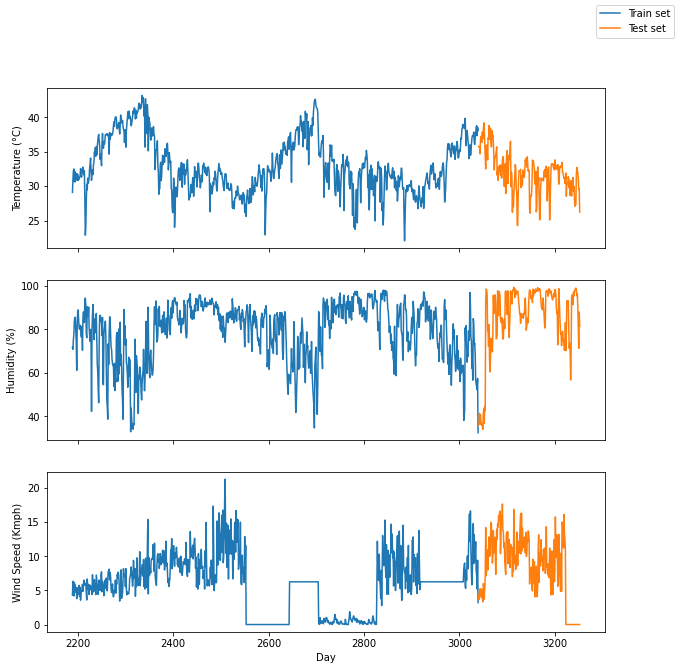

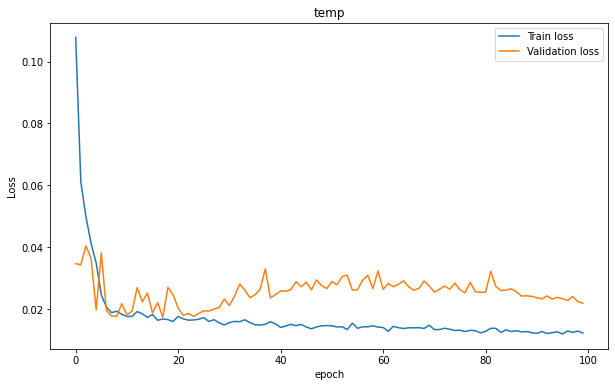

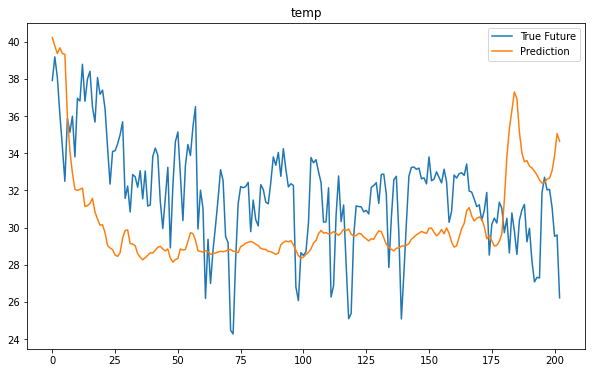

humid
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Hyderabad humid model saved to disk


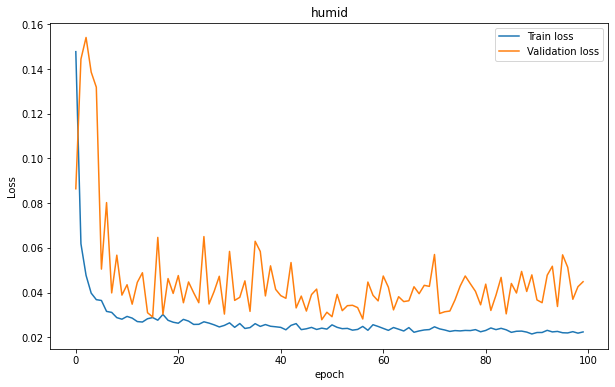

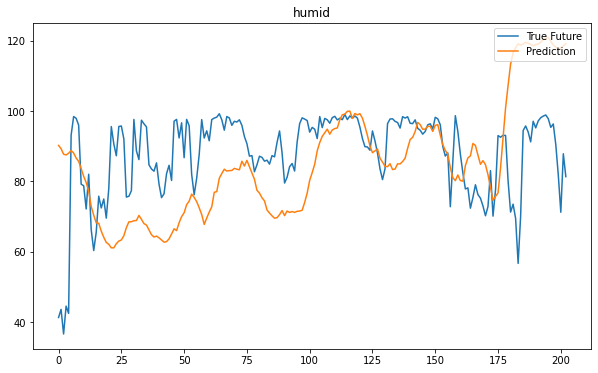

wind
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Hyderabad wind model saved to disk


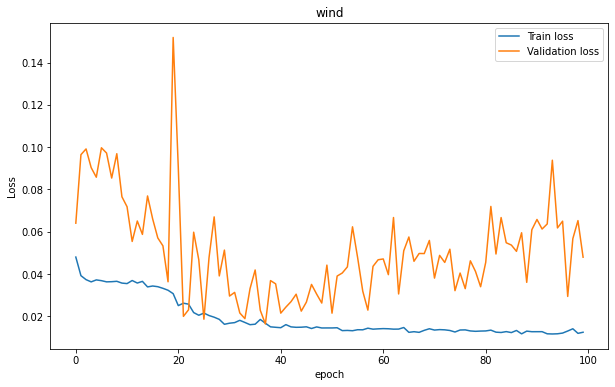

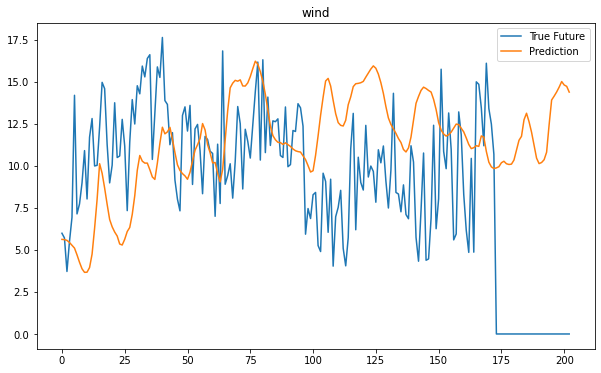

     District    Date       temp      humid      wind
3253  Jagtial     0.0  27.916667  89.573333  4.956667
3254  Jagtial     1.0  29.963333  91.790000  5.436667
3255  Jagtial     2.0  31.746667  92.063333  4.186667
3256  Jagtial     3.0  32.040000  93.640000  3.573333
3257  Jagtial     4.0  31.180000  92.453333  4.906667
...       ...     ...        ...        ...       ...
4312  Jagtial  1060.0  33.661111  99.633333  0.000000
4313  Jagtial  1061.0  33.033333  99.650000  0.000000
4314  Jagtial  1062.0  31.855556  98.544444  0.000000
4315  Jagtial  1063.0  32.205556  94.116667  0.000000
4316  Jagtial  1064.0  30.388889  93.844444  0.000000

[1064 rows x 5 columns]
temp
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Jagtial temp model saved to disk


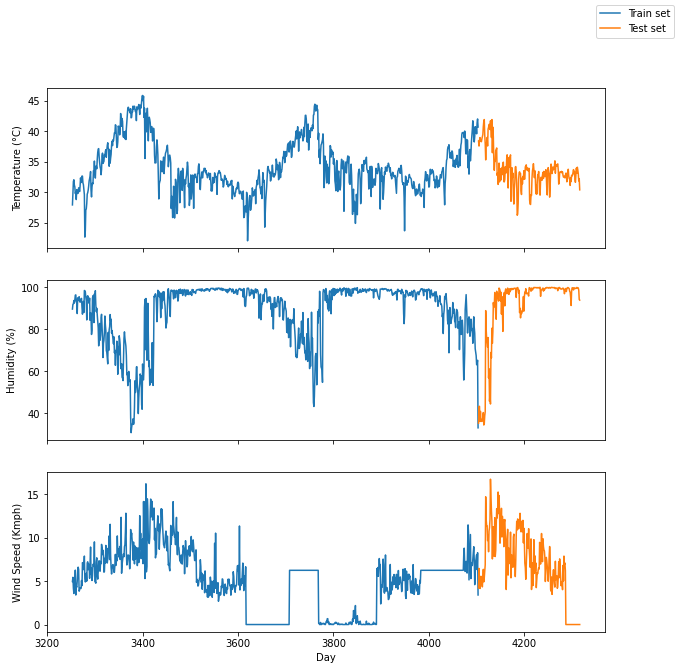

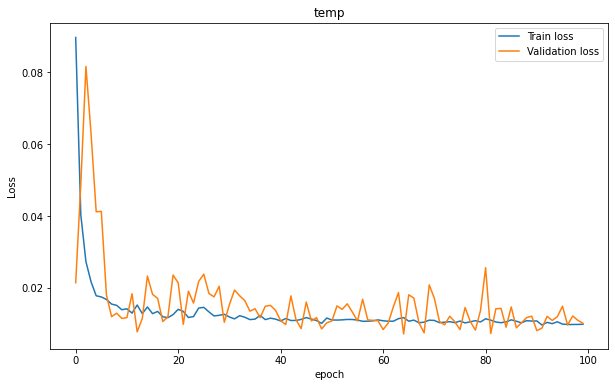

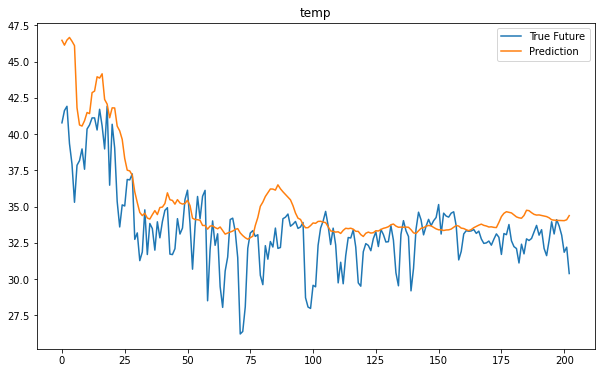

humid
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Jagtial humid model saved to disk


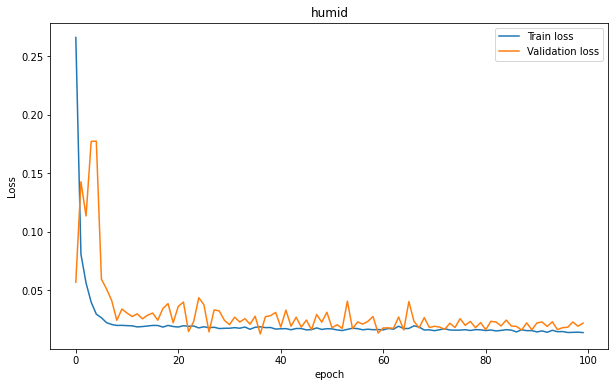

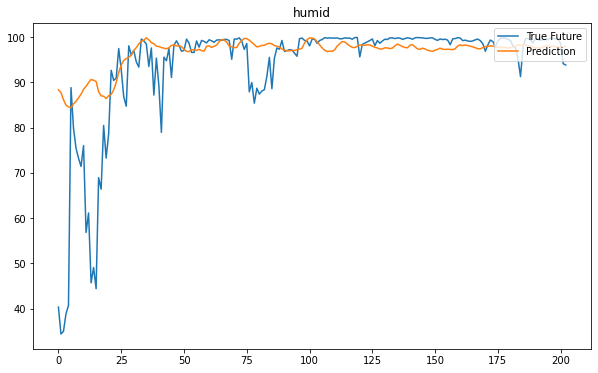

wind
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Jagtial wind model saved to disk


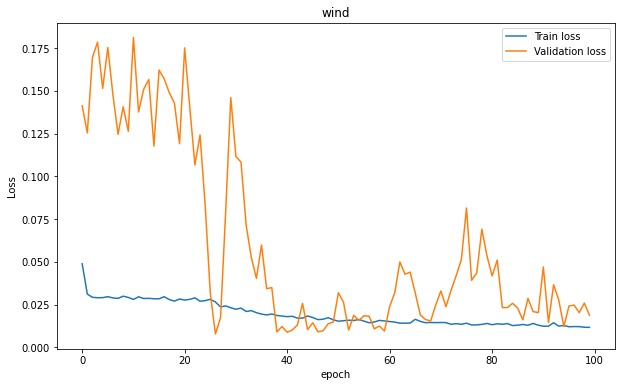

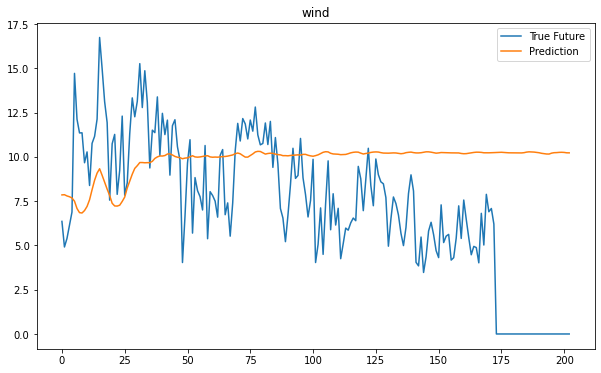

     District    Date       temp      humid      wind
4317  Jangaon     0.0  27.850000  73.405000  4.847368
4318  Jangaon     1.0  29.525000  73.835000  5.321053
4319  Jangaon     2.0  30.720000  91.570000  5.510526
4320  Jangaon     3.0  30.880000  90.400000  4.610526
4321  Jangaon     4.0  29.830000  91.495000  5.447368
...       ...     ...        ...        ...       ...
5376  Jangaon  1060.0  32.625000  97.600000  0.000000
5377  Jangaon  1061.0  32.050000  95.883333  0.000000
5378  Jangaon  1062.0  30.608333  86.625000  0.000000
5379  Jangaon  1063.0  29.725000  93.391667  0.000000
5380  Jangaon  1064.0  27.925000  80.458333  0.000000

[1064 rows x 5 columns]
temp
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Jangaon temp model saved to disk


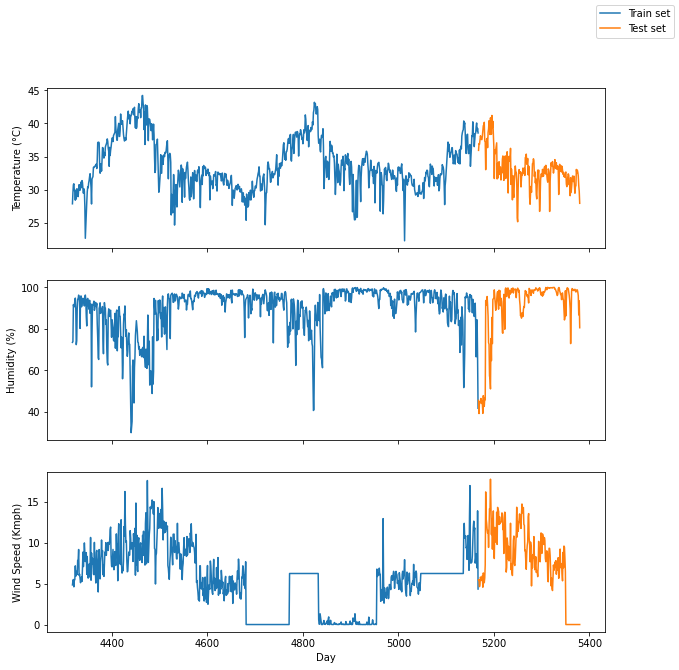

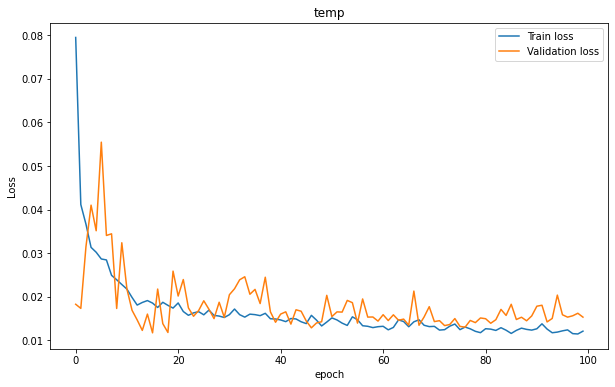

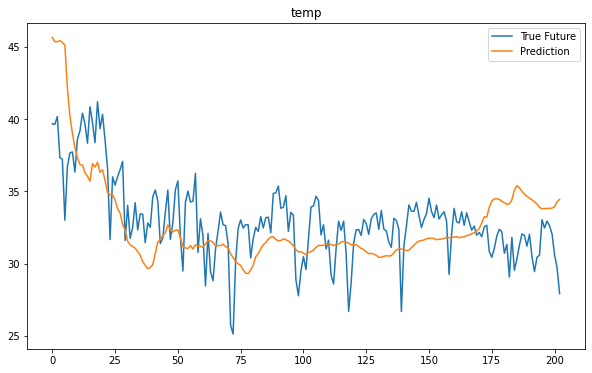

humid
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Jangaon humid model saved to disk


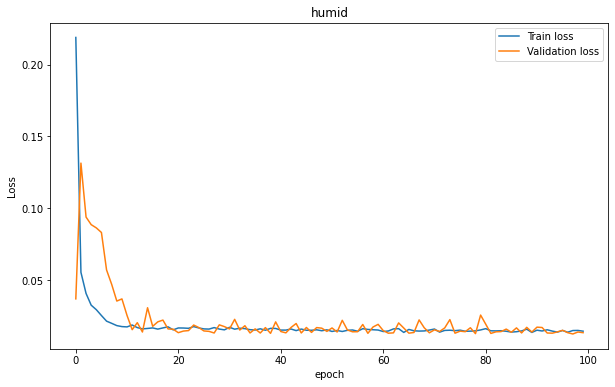

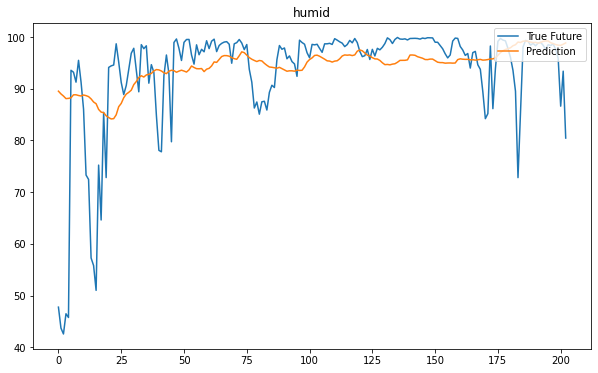

wind
X_train (841, 10, 3)
y_train (841, 1)
X_test (203, 10, 3)
y_test (203, 1)
Jangaon wind model saved to disk


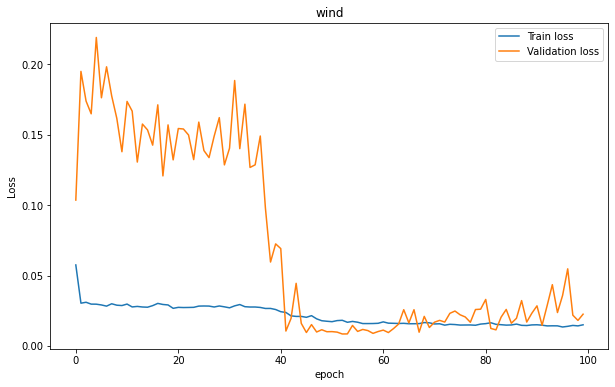

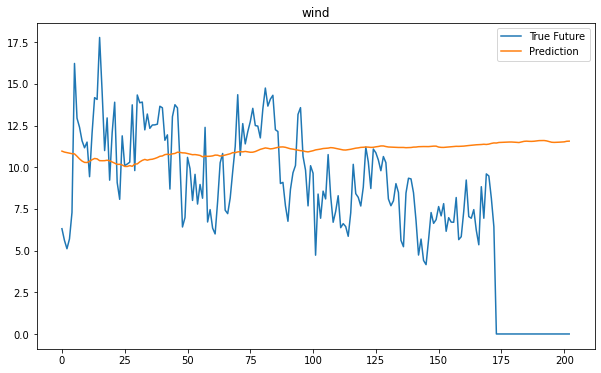

In [16]:
# Implements weather prediction for first 5 districts.

def main():
    for district in districts[:5]:
        train_dataset, test_dataset, district = data_splitting(df, district)
        for feature in features:
            modelling_training(train_dataset, test_dataset, district, feature)

if __name__ == "__main__":
    main()